<a href="https://colab.research.google.com/github/Rebel-C/Universidade_do_Porto/blob/master/UPorto_Vis%C3%A3o_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** TRABALHO PRÁTICO DA MATERIA DE VISÃO COMPUTACIONAL**


**INTRODUÇÃO**

Neste trabalho prático da matéria de Visão Computacional, exploraremos a técnica de transferência de estilo de uma obra de arte para uma fotografia, extraindo as características principais de uma pintura, extraindo o que torna aquela obra única e reproduzindo estas em uma fotografia, para tal usaremos as ferramentas de Deep Learning, entre elas o framework tensorflow do Google. Os conceitos aqui apresentados são a reprodução do brilhante trabalho realizado por Leon A. Gatys, Alexander S. Ecker e Matthias Bethge, no artigo denominado "A Neural Algorithm of Artistic Style" de 2015.

**TRANSFERINDO O ESTILO**

A transferência de estilo usando rede neural artificial é uma técnica que usa três imagens, onde a primeira é a que gostaríamos de ver com o estilo de uma pintura, normalmente uma foto, a segunda seria a imagem contendo o estilo ao qual gostaríamos de reproduzir, se usa com frequência uma pintura, mas a técnica se demostrou bem-sucedida com imagens diversas, quanto a terceira imagem, se trata do resultado da transferência de estilo, que no caso de optar por uma pintura como fonte de estilo e uma foto como alvo, esta terceira imagem deve apresentar como resultado uma imagem se assemelharia como uma pintura realizada pelo artista, com a imagem da foto e as características da pintura como textura, tons e matizes.

**NA PRÁTICA**

A principal característica da transferência de estilo é definição de distância que defini o quão distante estão as duas imagens, isso se dá por dois processos, o primeiro é verificar a diferenças de conteúdo das duas imagens e o segundo identifica a distância entre os estilos. Assim com funções de perda e “backpropagation” ao longo do caminho se vai verificando se a imagem final está distante ou não da imagem de estilo, até que haja um aceitável entre o estilo e a imagem de entrada, desta forma se transfere o estilo sem que a mesma perca suas características principais.




**DESCRIÇÃO DO CÓDIGO**

**IMPORTAR E CONFIGURAR MODULOS**
Neste momento se inicia a importação das bibliotecas e suas configurações, com ênfase em tensorflow.


DESCRIÇÃO DO CÓDIGO

ADQUISIÇÃO DE IMAGENS PARA EXPERIMENTO VIA INTERNET

In [0]:
import os
img_dir = '/tmp'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/ https://o-tuga.com/wp-content/uploads/2018/07/Porto-Portugal-o-tuga.jpg
!wget --quiet -P /tmp/ https://static.posters.cz/image/750/quadros/landscape-with-bridge-1900-i19998.jpg

IMPORTAR E CONFIGURAR MODULOS
Neste momento se inicia a importação das bibliotecas e suas configurações, com ênfase em tensorflow.

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [3]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
# entrada das imagens
content_path = '/tmp/Porto-Portugal-o-tuga.jpg'
style_path = '/tmp/landscape-with-bridge-1900-i19998.jpg'

VISUALIZAÇÃO DAS IMAGENS DE ENTRADA

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # Precisamos transmitir o array de imagens de forma que ele tenha uma dimensão de lote 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remover a dimensão do lote
  out = np.squeeze(img, axis=0)
  # Normalize para exibição 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

Apresenta-se a imagem de entrada e imagem de estilo

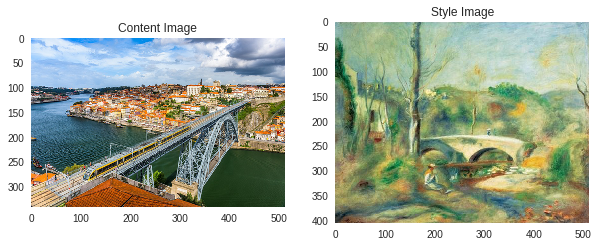

In [6]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

**PREPARAÇÃO DO CENÁRIO**

Criação de módulos para carregar e pré-processar as imagens. Estes utilizam a rede VGG que é treinada anteriormente uma grande gama de imagens.


In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

Como a imagem otimizada pode ter seus valores em qualquer lugar entre –infinito e infinito, precisamos limitar nossos valores em um intervalo entre 0 e 255.

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # executar o inverso da etapa de pré-processamento
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

**DEFINIR A REPRESENTAÇÃO DE CONTEÚDO E ESTILO**
Temos que analisar algumas camadas intermediárias para obter a representação das imagens de origem e destino, usando arquitetura VGG 19 que é uma rede de classificares pré-treinadas, entendemos que estas camadas são necessárias para definir a representação de imagem alvo e estilo, assim para uma imagem de entrada, tentaremos corresponder as representações de estilo e de conteúdo de destino correspondentes nessas camadas intermediárias.

**POR QUE ESTAS CAMADAS INTERMEDIÁRIAS SÃO NECESSÁRIAS?**
A rede deve entender através da classificação o conteúdo das imagens, transformando pixels em uma compreensão complexa das características das imagens. Portanto, poderemos assim descrever o conteúdo e estilo das imagens de entrada, decidindo posteriormente como se aplicam as transformações, levando em consideração destas, como por exemplo, um rosto, uma casa, céu, etc.

Abaixo a extração de destas camadas intermediárias


In [0]:
#Camada de conteúdo onde vai puxar nossos mapas de recursos
content_layers = ['block5_conv2'] 

#Camada de estilo em que estamos interessados
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

**INICIANDO A CRIAÇÃO DO MODELO**

Carregamos a VGG19 e alimentando o tensor de entrada para o modelo, isso extrairá os mapas de recursos de estilo e conteúdo, se usa VGG19 por ser um modelo simples comparado com ResNet,  Inception e outros, os mapas de recursos simplesmente funcionam e de forma satisfatória para a transferência de estilos.
Os mapas de características das camadas intermediárias são acessados pela KERAS Functional API, definindo nosso modelo de saída desejada.

Este solicita somente o modelo de entrada e saída. “model = Model(inputs, outputs)”.

In [0]:
def get_model():
  """ Cria nosso modelo com acesso a camadas intermediárias.
  
   Esta função carregará o modelo VGG19 e acessará as camadas intermediárias.
   Essas camadas serão então usadas para criar um novo modelo que receberá a imagem de entrada
   e retornar as saídas dessas camadas intermediárias do modelo VGG.
  
   Retorna:
     retorna um modelo de keras que recebe entradas de imagem e gera o estilo e
       camadas intermediárias de conteúdo. 
  """
  # Carregue nosso modelo. Carregamos o VGG pré-treinado, treinado em dados imagenet
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  #Obter camadas de saída correspondentes às camadas de estilo e conteúdo 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Contruir modelo
  return models.Model(vgg.input, model_outputs)

Após a classificação acima, usaremos as camadas de interesse como definido anteriormente. Posteriormente é definido o modelo de entradas e modelo de saídas, ou seja, temos um modelo estiliza as camadas intermediárias.



**CRIANDO LOSS FUNCTION**

**CONTENT LOSS**

Em um processo simples, a perda de conteúdo se dá na passagem de conteúdo à rede onde simplesmente tomamos a distância euclidiana entre duas representações intermediárias dessas imagens.
A Loss Function descreve a distância do conteúdo da imagem da imagem de saída, neste caso se usa novamente a VGG19.
Backpropagation é usada para minimizar as perdas de conteúdo, sendo assim, altera a imagem inicial até gerar uma semelhante em uma determinada camada como a imagem original

**COMPUTING CONTENT LOSS**

Todas as perdas de conteúdo através do modelo serão apropriadamente computadas e todos os gradientes serão computados.

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

**STYLE LOSS**

Seguindo o mesmo princípio do Content Loss, no Style Loss alimentamos a rede com as imagens de entrada e a imagem de estilo, contudo, em vez de comparar as saídas intermediárias, comparamos as matrizes das duas saídas.
Para gerar o estilo em nossa imagem de entrada, realizamos a descida do gradiente da imagem de conteúdo para transformá-la em uma imagem que corresponda a representação do estilo da imagem original.

**COMPUTING STYLE LOSS**

Implementamos a perda com a distância medida

In [0]:
def gram_matrix(input_tensor):
  # Nós fazemos os canais de imagem primeiro
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Espera-se duas imagens de dimensão h, w, c"""
  # Altura, largura, num filters de cada camada
  # Nós dimensionamos a perda em uma determinada camada pelo tamanho do mapa de recursos e pelo número de filtros
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (Canais ** 2) * (largura * Altura) ** 2)

**TRANSFERÊNCIA DE ESTILO PARA AS IMAGENS**

Desta vem se utilizará Adam Optimizer para minimizar as perdas atualizando as interativamente a imagem de saída e não atualizando os pesos associados a rede, mas treinando a imagem de entrada para minimizar a perda, para isso é preciso calcular o Loss e Gradient.

In [0]:
def get_feature_representations(model, content_path, style_path):
  """Função auxiliar para calcular nossas representações de recursos de estilo e conteúdo.

   Esta função irá simplesmente carregar e pré-processar o conteúdo e o estilo
   imagens de seu caminho. Em seguida, ele irá alimentá-los através da rede para obter
   as saídas das camadas intermediárias.
  
   Argumentos:
     model: O modelo que estamos usando.
     content_path: o caminho para a imagem de conteúdo.
     style_path: o caminho para a imagem do estilo
    
   Retorna:
     retorna os recursos de estilo e os recursos de conteúdo. 
  """
  # Carrega nossa imagem de entrada
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # Recursos de conteúdo e estilo de computação em lote
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Obtenha as representações de recursos de estilo e conteúdo do nosso modelo
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

**COMPUTANDO A LOSS E GRADIENTS**

Com a função do Tensorflow (tf.GradientTape) calculamos o gradiente, permitindo assim verificar as diferenças para calcularmos posteriormente o gradiente, registrando assim a cada passo e possibilitando calcular o gradiente da nossa função de perda e imagem de entrada. 

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  '''Esta função calculará a perda total da perda.
  
   Argumentos:
     model: O modelo que nos dará acesso às camadas intermediárias
     loss_weights: Os pesos de cada contribuição de cada função de perda.
       (peso do estilo, peso do conteúdo e peso total da variação)
     init_image: nossa imagem base inicial. Esta imagem é o que estamos atualizando com
       nosso processo de otimização. Aplicamos os gradientes com a perda que somos
       calculando para esta imagem.
     gram_style_features: matrizes grama pré-computadorizadas correspondentes ao
       camadas de estilo de interesse definidas.
     content_features: Saídas pré-computadas de camadas de conteúdo definidas de
       interesse.
      
   Retorna:
     retorna a perda total, perda de estilo, perda de conteúdo e perda variacional total
 '''
  style_weight, content_weight = loss_weights
  
  '''Alimente nossa imagem de inicialização através do nosso modelo. Isso nos dará o conteúdo e
     representacoes de estilo em nossas camadas desejadas Desde que estamos usando ansioso
     nosso modelo é chamado como qualquer outra função'''
 
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  '''Acumule perdas de estilo de todas as camadas
     Aqui, nós igualmente ponderamos cada contribuição de cada camada de perda'''
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Acumule perdas de conteúdo de todas as camadas 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Obter perda total
  loss = style_score + content_score 
  return loss, style_score, content_score

Isso facilita o cálculo do gradiente que se dá neste momento

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
# Compute gradientes wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

**LOOP DE OTIMIZAÇÃO**

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # Não precisamos treinar nenhuma camada do nosso modelo, então definimos trainable como falso.
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Obtenha as representações de recursos de estilo e conteúdo (de nossas camadas intermediárias especificadas)
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Definimos a imagem inicial
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Criar a otimização
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # Para exibir imagens intermediárias
  iter_count = 1
  
  # Armazene nosso melhor resultado
  best_loss, best_img = float('inf'), None
  
  # Crie uma configuração legal
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # Para exibir
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Atualize a melhor perda e a melhor imagem da perda total.
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use o método .numpy () para obter o array numpy concreto
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

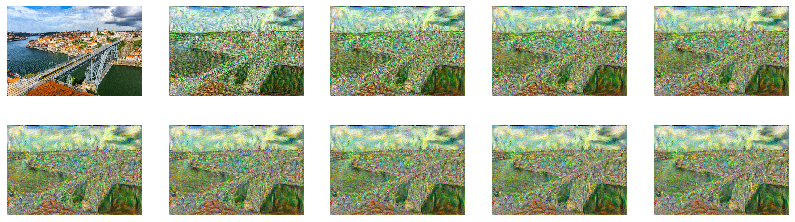

In [31]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

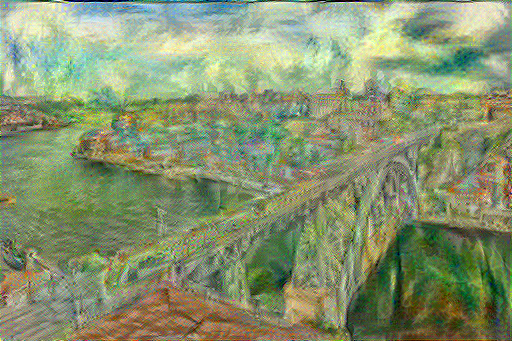

In [32]:
Image.fromarray(best)